# Zaawansowane Metody Inteligencji Obliczeniowej
## Lab 8: Q-Learning z aproksymacją
### Prowadzący: Michał Kempka, Marek Wydmuch

## Wprowadzenie

Celem tego ćwiczenia jest implementacja algorytmu Q-Learning z aproksymacją dla środowiska `CartPole` ze znanej Wam już bibliteki ~~OpenAI Gym~~ Gymnasium (https://gymnasium.farama.org/), która jest kontynuacją biblioteki Gym.


Zapoznaj się z opisem środowiska (https://gymnasium.farama.org/environments/classic_control/cart_pole/) następnie zapoznaj się z kodem poniżej. Pokazuje on przykład użycia omawianego środowiska.

In [ ]:
# Zainstaluj bibliotekę Gymnasium i PyTorch
!pip install gymnasium == 0.28 torch matplotlib numpy

### Środowisko `CartPole`

Poniższy kod demonstruje działanie środowiska `CartPole`

In [3]:
# Zobacz jak działa środowisko na przykładzie 100 kroków
import gymnasium as gym
from time import sleep

# Inicjalizacja środowiska
env = gym.make("CartPole-v1", render_mode="human")
observation, _ = env.reset()

for _ in range(100):
  # Pokaż obraz z środowiska
  env.render()

  # Wybierz losową akcję z przestrzeni akcji
  action = env.action_space.sample()

  # Wykonaj akcję i otrzymaj informację o kolejnym stanie, nagrodzie
  # i czy środowisko zostało zakończone.
  # Zobacz https://gymnasium.farama.org/api/env/#gymnasium.Env.step
  # by sprawdzić opis wszystkich zwracanych wartości.
  observation, reward, term, trunc, _ = env.step(action)
  done = term or trunc

  if done:
    observation, _ = env.reset()
env.close()

In [4]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Ostatnia obserwacja:", observation)
print("Przestrzeń akcji:", env.action_space)

Przestrzeń stanów: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Ostatnia obserwacja: [-0.03351276 -0.441069    0.08434602  0.8963627 ]
Przestrzeń akcji: Discrete(2)


### Regresja w PyTorch

Poniższy kod demosntruje jak stworzyć prosty model za pomocą bilibteki PyTorch dla problemu regresji.

In [5]:
import torch
import torch.nn.functional as F


class MyModel(torch.nn.Module):
  def __init__(self, n_feature, n_hidden, n_output):
    super(MyModel, self).__init__()
    self.hidden = torch.nn.Linear(n_feature, n_hidden)  # Warstwa wejściowa
    self.predict = torch.nn.Linear(n_hidden, n_output)  # Warstwa wyjściowa

  # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
  def forward(self, x):
    x = F.relu(self.hidden(x))  # Wejście + funkcja aktywacji
    x = self.predict(x)  # Liniowe wyjście
    return x


h = MyModel(n_feature=1, n_hidden=50, n_output=1)

# Poza samym modelem, w celu jego uczenia potrzebujemy optymalizatora (w tym wypadku algorytmu SGD)
optimizer = torch.optim.SGD(h.parameters(), lr=0.2)

# Oraz naszej funkcji straty, w tym wypadku uyjmy błędu kwadratowego
loss_func = torch.nn.MSELoss()

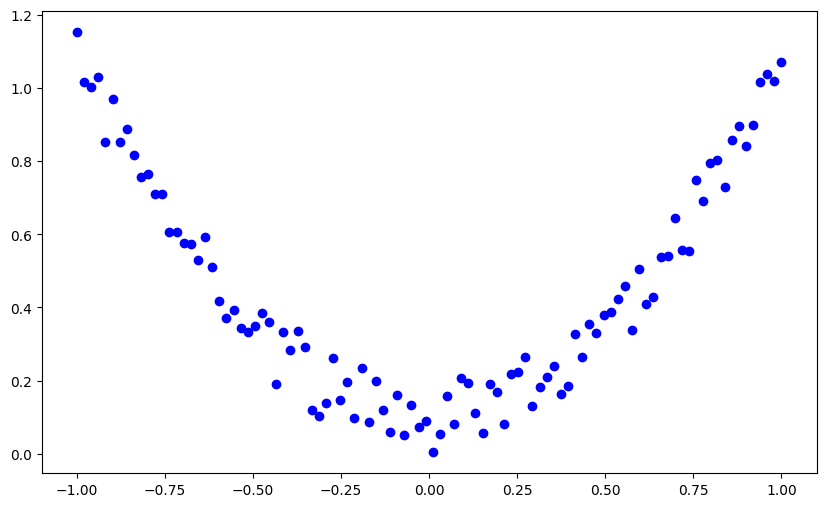

In [6]:
# Stwórzmy przykładowe, jednowmiarowe dane i wyświetlmy je
import matplotlib.pyplot as plt
% matplotlib inline

torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(2) + 0.2 * torch.rand(x.size())

plt.figure(figsize=(10, 6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.show()

In [7]:
# Wytrenujmy nasz model wykonując 1000 iteracji po całym zbiorze danych
for t in range(1000):
  # Dokonaj predykcji na podstawie x
  prediction = h(x)

  # Wyliczmy błąd
  loss = loss_func(prediction, y)

  # Wyzerujmy gradienty
  optimizer.zero_grad()

  # Wylicz gradienty dla każdej operacji z użyciem propagacji wstecznej
  loss.backward()

  # Zaktualizuj wagi
  optimizer.step()

In [8]:
# Wykonajmy ostateczną predykcję, nie potrzebujemy już gradientów ani grafu obliczeniowego
with torch.no_grad():
  prediction = h(x)

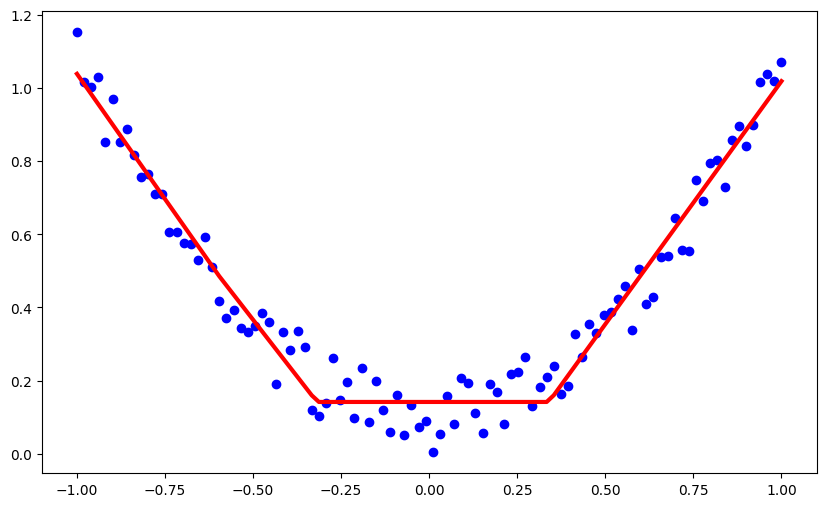

In [9]:
# Wyświetlmy wyniki
plt.figure(figsize=(10, 6))
plt.scatter(x.data.numpy(), y.data.numpy(), color="blue")
plt.plot(x.data.numpy(), prediction.data.numpy(), color="red", lw=3)
plt.show()

## Ćwiczenie: zaimplementuj algorytm Q-Learning z aproksymacją dla środowiska `CartPole`

In [27]:

class CartPoleModel(torch.nn.Module):
  def __init__(self, n_feature, n_hidden, n_output):
    super(CartPoleModel, self).__init__()
    self.input = torch.nn.Linear(n_feature, n_hidden)
    self.hidden = torch.nn.Linear(n_hidden, n_hidden)
    self.output = torch.nn.Linear(n_hidden, n_output)

  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.relu(self.hidden(x))
    x = self.output(x)
    return x

  def predict(self, value, pass_grad=False):
    if pass_grad: return self.forward(torch.Tensor(value))
    with torch.no_grad(): return self.forward(torch.Tensor(value))


In [32]:
from random import random
from gymnasium import Env
from torch.optim import Optimizer

def epsilon_greedy_policy(model: CartPoleModel, observation: list[float], epsilon: float):
  if random() < epsilon: return env.action_space.sample()
  return model.predict(observation, pass_grad=True).argmax().item()

def q_learning(env: Env, model: CartPoleModel, optimizer: Optimizer, gamma: float, epsilon: float, epsilon_decay: float, episodes: int):
  loss_fn = torch.nn.MSELoss()
  rewards: list[int] = []

  for _ in range(episodes):
    observation, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
      action = epsilon_greedy_policy(model, observation, epsilon)
      old_observation = observation
      observation, reward, done, trunc, _ = env.step(action)
      done = done or trunc

      total_reward += reward

      optimizer.zero_grad()


      if done:
        target = reward
      else:
        target = reward + gamma * model.predict(observation, pass_grad=True).max().item()

      prediction = model.predict(old_observation, pass_grad=True)[action]

      # Oblicz błąd
      loss = loss_fn(prediction, torch.Tensor([target]))

      # Oblicz gradienty
      loss.backward()

      # Zaktualizuj wagi
      optimizer.step()

    epsilon = max(epsilon * epsilon_decay, 0.01)
    rewards.append(total_reward)

  return rewards


In [33]:
env = gym.make("CartPole-v1")
h = CartPoleModel(env.observation_space.shape[0], 64, env.action_space.n)
optimizer = torch.optim.SGD(h.parameters(), lr=0.001)

In [34]:
rewards = q_learning(env, h, optimizer, episodes=1000, gamma=0.90, epsilon=0.20, epsilon_decay=0.99)

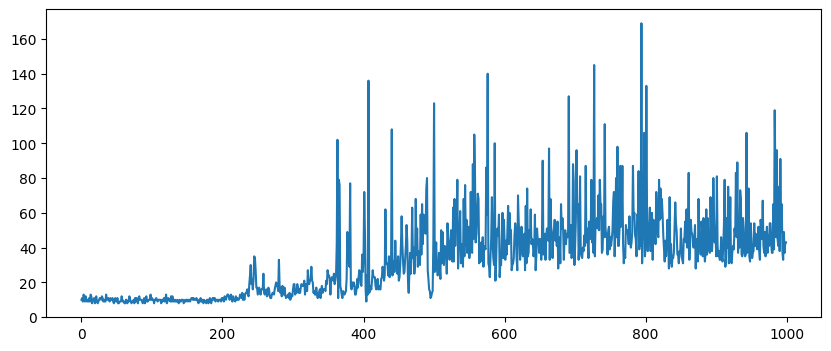

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(rewards)
plt.show()